## Title

Generative Adversarial Networks
- Generate 1D Gaussian Distribution from Uniform Noise 

## Description

In this exercise, we are going to generate 1-D Gaussian distribution from a n-D uniform distribution. This is a toy exercise in order to understand the ability of GANs (generators) to generate arbitrary distributions from random noise.


## Hints

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_on_batch" target="_blank">tf.keras.Model.train_on_batch()</a> tf.keras.Model.train_on_batch()

Runs a single gradient update on a single batch of data.

<a href="https://numpy.org/doc/stable/reference/generated/numpy.ones.html" target="_blank">np.ones</a> np.ones

<a href="https://numpy.org/doc/stable/reference/generated/numpy.zeros.html" target="_blank">np.zeros</a> np.zeros

##  🎨 Generative Models 🖼

Generate 1-D Gaussian distribution from a n-D uniform distribution
  
  <hr>
In this exercise, we are going to generate 1-D Gaussian distribution from a n-D uniform distribution.  This is a toy exercise in order to understand the ability of GANs (generators) to generate arbitrary distributions from random noise.

In [227]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import plot_model
%matplotlib inline

tf.random.set_seed(109)
np.random.seed(109)

In [228]:
!rm -rf ./logs/ 

/usr/bin/zsh: /home/ting/ENTER/envs/cs109a/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)


In [229]:
#This is our real dataset (samples from stanard normal distribution )
def generate_data(n_samples = 10000,n_dim=1):
    np.random.seed(109)
    return np.random.randn(n_samples, n_dim) 
    

In [230]:
# A general function to define feedforward architecture.
def make_model(input_dim, 
               output_dim, 
               hidden_dim=64,
               n_layers = 1,
               activation='tanh',
               optimizer='adam',
               loss = 'binary_crossentropy'):
    
    model = Sequential()
    model.add(Dense(hidden_dim,input_dim=input_dim,activation=activation))
    
    for _ in range(n_layers-1):
        model.add(Dense(hidden_dim),activation=activation)
    model.add(Dense(output_dim))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [231]:
# hyper-parameters
NOISE_DIM = 100
DATA_DIM = 1   #this is equivalent to image size e.g. 32*32*3
G_LAYERS = 1
D_LAYERS = 1
generator = make_model(NOISE_DIM, DATA_DIM, n_layers=G_LAYERS)  
discriminator = make_model(DATA_DIM, 1, n_layers= D_LAYERS, activation='sigmoid')  
 

In [232]:
def get_gan_network(random_dim, optimizer = 'adam'):
    
    #This ensures that when we combine our networks we only train the Generator.
    #While generator training we do not want discriminator weights to be adjusted. 
    discriminator.trainable = False
    
    gan_input = Input(shape=(random_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    #this model will be used to train generator
    gan = tf.keras.Model(inputs = gan_input,outputs=gan_output)
    gan.compile( loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [233]:
x_train = generate_data(n_samples=12800,n_dim=DATA_DIM)
x_train.shape

(12800, 1)

In [234]:
def train_gan(epochs=15,batch_size=128):
    #Loads the real data 
    x_train = generate_data(n_samples=12800,n_dim=DATA_DIM)  
    gan = get_gan_network(NOISE_DIM, 'adam') # Get GAN model 

    for e in range(1,epochs+1):   
        np.random.seed(109 + e)
        # noise from a uniform distribution 
        noise = np.random.rand(batch_size,NOISE_DIM) 
        # generate a batch of fake data/images)
        generated_values = generator.predict(noise)
        # the generator model has not been trained, but can still make predictions (using random parameters)
        # !!!!!!!!
        
        #Gets a batch of real data (images)
        true_batch = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]  

        # Train discriminator on real data, use train_on_batch
        # real data has label of all 1s
        # train_on_batch: training a neural network model on a single batch of data.
        disc_history_true =  discriminator.train_on_batch(true_batch, np.ones(batch_size))
        # y should be np.ones(batch_size), instead of 1
        # !!!!!!!!!!!!!
        # Train discriminator on generated values, use train_on_batch
        # fake data has label of all 0s
        disc_history_noise = discriminator.train_on_batch(generated_values, np.zeros(batch_size))

        # Train generator/GAN
        noise = np.random.rand(batch_size,NOISE_DIM)
        y_gen = np.ones(batch_size)      
        # Train gan with noise, with label all 1s. 
        gan_loss = gan.train_on_batch(noise, y_gen)
        # train gan instead of generator
        # !!!!!!!!!!!!!
        # why the loss function for generator is binary cross entropy but not mse

        
    return generator, discriminator, gan_loss, disc_history_true, disc_history_noise
generator, discriminator, gan_loss, disc_history_true, disc_history_noise = train_gan()

4/4 [==============================] - 0s 718us/step


In [235]:
### edTest(test_check) ###
print( gan_loss, disc_history_true, disc_history_noise)


15.424948692321777 15.424948692321777 0.0


313/313 [==============================] - 0s 394us/step
1st order moment -  True :  0.0 , GAN : [0.]
2nd order moment -  True :  1.0087953803288114 , GAN : [0.11866782]
3rd order moment -  True :  0.02760037451420669 , GAN : [0.00060622]
4th order moment -  True :  2.99484726484523 , GAN : [0.04226395]


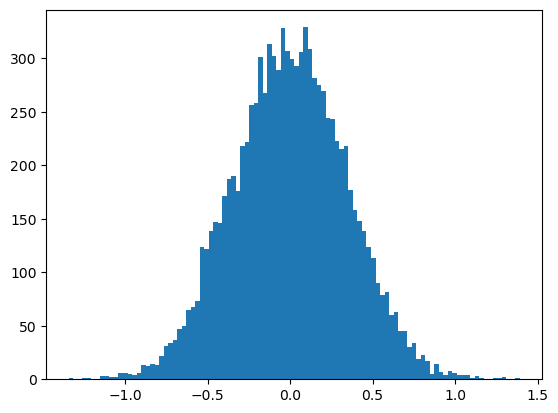

In [236]:
noise = np.random.rand(10000,NOISE_DIM)
generated_values = generator.predict(noise)
plt.hist(generated_values,bins=100)

true_gaussian = [np.random.randn() for x in range(10000)]
# np.random.randn: If no argument is given a single Python float is returned.
# !!!!!!!
# It's a common convention in Python list comprehensions to use a variable placeholder (like x) when you need to iterate a specific number of times, 
# but you don't actually use the variable in the expression that generates the list.

print('1st order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 1) , ', GAN :', scipy.stats.moment(generated_values,1))
# mean, but different from the mean, should be the mean of difference between mean and each value
# https://www.youtube.com/watch?v=ISaVvSO_3Sg
print('2nd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 2) , ', GAN :', scipy.stats.moment(generated_values,2))
# variance
print('3rd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 3) , ', GAN :', scipy.stats.moment(generated_values,3))
# skewness
print('4th order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 4) , ', GAN :', scipy.stats.moment(generated_values,4))
# kurtosis
plt.show()

<div class="alert alert-block alert-info">
    <h3>CONCLUSIONS </h3>     <br/>

1. GANs are able to learn a generative model from general noise distributions. <br/>

2. Traditional GANs do not learn the higher-order moments well. Possible issues : Number of samples, approximating higher moments is hard. Usually known to under-predict higher order variances. For people interested in learning why, read more about divergence measures between distributions (particularly about Wasserstein etc.)
    </div>
    

#### References

- GANs in Action (Jakub Langr; Vladimir Bok) 
- https://machinelearningmastery.com/generative-adversarial-network-loss-functions/ 
- https://arxiv.org/pdf/1406.2661.pdf